In [ ]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [ ]:
#First Create a dataset using a range, which simplu makes the dataset contain the values 0 to n-1, where n is, in this case 10
dataset = tf.data.Dataset.range(10)


#Split the dataset into windows of 5 items.
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())
  

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
  print("x= ", x.numpy())
  print("y= ", y.numpy())


x=  [[2 3 4 5]
 [4 5 6 7]]
y=  [[6]
 [8]]
x=  [[5 6 7 8]
 [3 4 5 6]]
y=  [[9]
 [7]]
x=  [[1 2 3 4]
 [0 1 2 3]]
y=  [[5]
 [4]]


In [ ]:
def trend(time, slope = 0):
  return slope*time

def seasonal_pattern(season_time):
  return np.where(season_time< 0.4, np.cos(season_time*2*np.pi), 1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time+phase)%period)/ period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

time = np.arange(4*365 +1, dtype="float32")

series = trend(time, 0.1)
baseline=10
amplitude=20
slope=0.09
noise_level=5

series = baseline+trend(time, slope)
series+=seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
#get a training ready dataset
split_time=1000
time_train= time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size=20
batch_size=32
shuffle_buffer_size=1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
#inspect what the dataset looks like 
dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
  print(feature)
  print(label)

tf.Tensor(
[[100.87476  101.50936  102.13909  101.593666 102.63381  106.13124
  100.53356  103.16166   99.23384  106.94918   96.43291  108.88604
   99.74721   92.86098  100.72242   96.743866 104.419754  97.02101
   98.121     90.97218 ]], shape=(1, 20), dtype=float32)
tf.Tensor([98.2265], shape=(1,), dtype=float32)


In [ ]:
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape=[window_size],
                                                          activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))


In [ ]:
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
46/46 [==============================] - 2s 5ms/step - loss: 3110.9122
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 61.9048
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 55.4198
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 63.4093
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 67.5115
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 52.6798
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 52.6002
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 49.5577
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 48.9282
Epoch 10/100
46/46 [==============================] - 0s 4ms/step - loss: 46.3486
Epoch 11/100
46/46 [==============================] - 0s 4ms/step - loss: 47.1392
Epoch 12/100
46/46 [==============================] - 0s 3ms/step - loss: 45.3032
Epoch 13/100
46/46 [===

In [ ]:
print(series[1000:1020])

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]


In [ ]:
print(series[1020])

106.258606


In [ ]:
print(model.predict(series[1000:1020][np.newaxis]))

[[101.52576]]


In [ ]:
#print(series[start_point:start_point+window_size])
#print(series[start_point+window_size])
#print(model.predict(series[start_point: start_poimt+window_size][np.newaxis]))

In [ ]:
#Exploring the overall prediction 
forecast = []
for time in range(len(series)- window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

In [ ]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

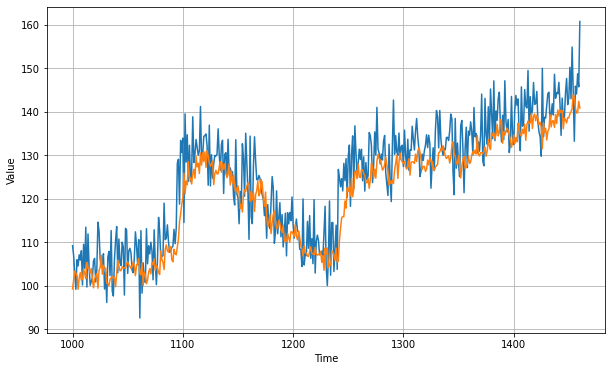

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.204118

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history =model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

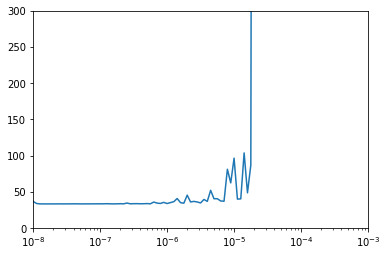

In [ ]:
lrs= 1e-8*(10**(np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

In [ ]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset, epochs=100, verbose=1)


Epoch 1/100
46/46 [==============================] - 0s 3ms/step - loss: 1787.0593
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 1804.8011
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 1743.5618
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 1704.8151
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 1698.6137
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 1754.3207
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 1755.0458
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 1748.1841
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 1674.9506
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 1787.7146
Epoch 11/100
46/46 [==============================] - 0s 3ms/step - loss: 1701.7706
Epoch 12/100
46/46 [==============================] - 0s 4ms/step - loss: 1630.2507
E

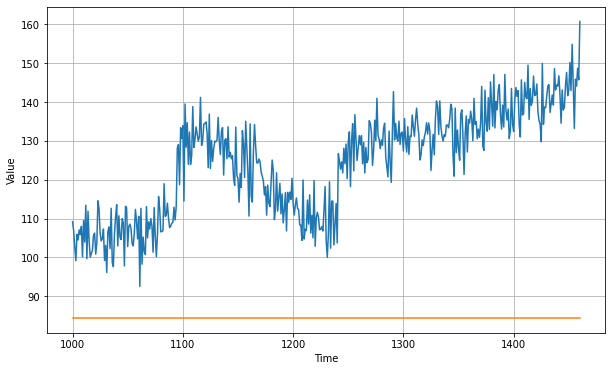

In [ ]:
#Exploring the overall prediction 
forecast = []
for time in range(len(series)- window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

  
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 6.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=ec3c626fb0c487318f27a827805917f6e8e12cc5437e20b91383741815c1e917
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=4d8608e1387187a5aefdf0a6cf838622e43002b3b8d46d599fdb540732974f27
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
#tf.keras.layers.Dense(units=hp.Int('units', min_value=10, max_value=30, step=2), activation='relu', input_shape=[window_size]))

#optimizer = tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.9,0.7,0.5,0.3]), lr=1e-5)

In [ ]:
def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add( tf.keras.layers.Dense(
      units=hp.Int('units', min_value=10, max_value=30, step=2), activation='relu', input_shape=[window_size])
  )
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model. compile(loss="mse", optimizer = tf.keras.optimizers.SGD(hp.Choice('momentum', values =[0.9, 0.7, 0.5, 0.3]), lr=1e-5))
  return model 

In [ ]:
from kerastuner.tuners import RandomSearch

In [ ]:
tuner = RandomSearch(build_model, objective='loss', max_trials=15, executions_per_trial=3, directory='my_dir', project_name='hello')

In [ ]:
tuner.search(dataset, epochs=100, verbose=0)

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/hello
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
units: 16
momentum: 0.7
Score: 34.09426498413086
Trial summary
Hyperparameters:
units: 24
momentum: 0.9
Score: 34.45700709025065
Trial summary
Hyperparameters:
units: 14
momentum: 0.9
Score: 34.58451716105143
Trial summary
Hyperparameters:
units: 30
momentum: 0.3
Score: 34.6942990620931
Trial summary
Hyperparameters:
units: 30
momentum: 0.5
Score: 34.82014465332031
Trial summary
Hyperparameters:
units: 14
momentum: 0.5
Score: 34.85661315917969
Trial summary
Hyperparameters:
units: 24
momentum: 0.5
Score: 34.88518142700195
Trial summary
Hyperparameters:
units: 20
momentum: 0.9
Score: 34.92003377278646
Trial summary
Hyperparameters:
units: 28
momentum: 0.3
Score: 34.97399139404297
Trial summary
Hyperparameters:
units: 20
momentum: 0.7
Score: 35.028944651285805


In [ ]:
tuner.get_best_models(num_models=3)

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model  = tf.keras.models.Sequential([
                                     tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'),
                                     tf.keras.layers.Dense(16, activation='relu'),
                                     tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.7)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 2998.4632
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 89.5847
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 43.8829
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 42.5234
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 41.6097
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 44.8692
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 42.2481
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 45.1495
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 41.0553
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 46.9991
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 43.3310
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 41.9271
Epoch 13/100
31/31 [===

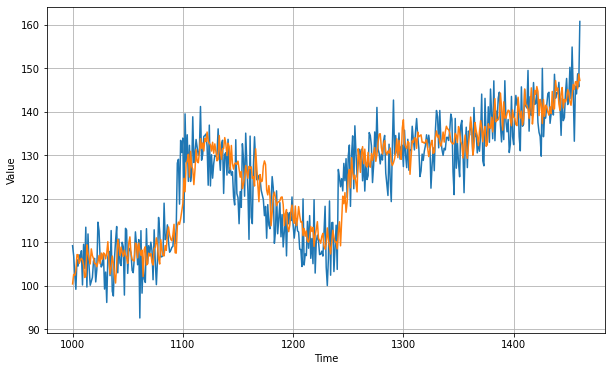

In [ ]:
#Exploring the overall prediction 
forecast = []
for time in range(len(series)- window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

  
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
#Coding convolutions 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True )
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [ ]:
dataset =  windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape = [None, 1]),
                                    tf.keras.layers.Dense(28, activation="relu"),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer = optimizer)
history = model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 15s 12ms/step - loss: 1249.4824
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 102.2995
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 88.2597
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 84.1558
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 70.6627
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 70.9935
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 64.5005
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 71.0927
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 62.5075
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 64.2985
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 64.1012
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 66.9020
Epoch 13/100
31/31 [

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift =1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
forecast = model_forecast(model, series[...,np.newaxis], window_size)

In [ ]:
results = forecast[split_time- window_size:-1,-1,0]

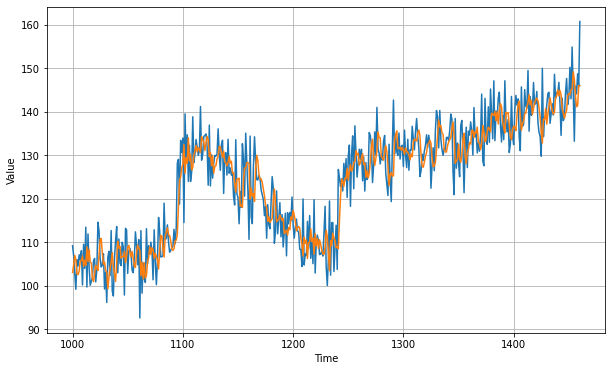

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(
      filters = hp.Int('units', min_value=128, max_value=256, step =64),
      kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
      strides = hp.Int('strides', min_value=1, max_value=3, step=1),
      padding='causal', activation='relu', input_shape = [None,1]
  ))

  model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(momentum=0.5, lr=1e-5))
  return model

In [ ]:
tuner  = RandomSearch(build_model, objective='loss', max_trials=10, executions_per_trial=3, directory='my_dirs', project_name='cnn_tunes')
tuner.search_space_summary()
tuner.search(dataset, epochs=10, verbose=2)

Trial 10 Complete [00h 00m 07s]
loss: 65.97730509440105

Best loss So Far: 63.4073600769043
Total elapsed time: 00h 01m 15s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in my_dirs/cnn_tunes
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 1
Score: 63.4073600769043
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 1
Score: 64.22253163655598
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 1
Score: 64.73221079508464
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 2
Score: 64.7905502319336
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 3
Score: 65.97730509440105
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 2
Score: 66.31611633300781
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 3
Score: 66.60069020589192
Trial summary
Hyperparameters:
units: 192
kernels: 3
strides: 2
Score: 67.14639536539714
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 3
Score: 67.23900349934895
Trial summary
Hyperparameters:
units: 256
kernels: 3
strides: 3
Score: 67.84997304280598


In [ ]:
"""
Best results:
kernels: 9
strides: 1
"""

'\nBest results:\nkernels: 9\nstrides: 1\n'

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                           tf.keras.layers.Conv1D(filters=128, kernel_size=9, 
                                                                  strides=1, padding="causal", activation="relu",
                                                                  input_shape=[None, 1]),
                                           tf.keras.layers.Dense(28, input_shape=[window_size], 
                                                                 activation='relu'), 
                                           tf.keras.layers.Dense(10, activation='relu'),
                                           tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 1050.9454
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 122.0160
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 87.0474
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 75.2648
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 76.4826
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 71.6508
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 65.9056
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 65.0484
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 68.0261
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 69.6480
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 63.1526
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 68.0125
Epoch 13/100
31/31 [==

In [ ]:
results = forecast[split_time- window_size:-1,-1,0]

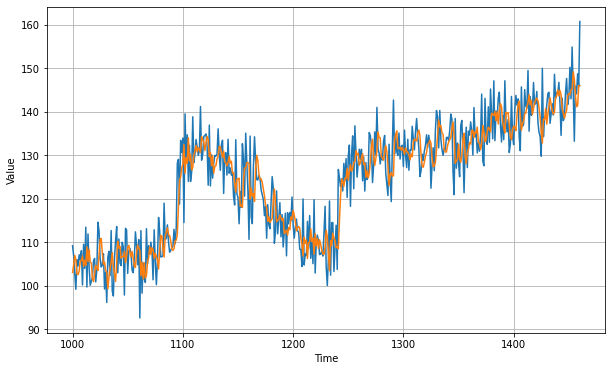

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive
%cd My Drive 
%cd FinTech
%cd bitcontext 
%pwd

Mounted at /content/gdrive
/content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/FinTech
/content/gdrive/My Drive/FinTech/bitcontext


'/content/gdrive/My Drive/FinTech/bitcontext'

In [ ]:
def get_data(data_file):
  f = open(data_file)
  data = f.read()
  f.close()
  lines = data.split('\n')
  header = lines[0].split(',')
  lines = lines[1:]
  temperatures = []
  for line in lines: 
    if line:
      linedata = line.split(',')
      linedata = linedata[1:13]
      for item in linedata:
        if item:
          temperatures.append(float(item))
  series = np.asarray(temperatures)
  time = np.arange(len(temperatures), dtype="float32")
  return time, series

In [ ]:
time, series = get_data("station.csv")
mean = series.mean(axis=0)
series -= mean 
std = series.std(axis=0)
series /=std

In [ ]:
split_time =792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
window_size = 24
batch_size=12
shuffle_buffer_size  = 48
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [ ]:
#Using RNNs for sequence modeling 
model = tf.keras.models.Sequential([
                                    tf.keras.layers.SimpleRNN(100, return_sequences=True, input_shape = [None, 1]),
                                    tf.keras.layers.SimpleRNN(100), 
                                    tf.keras.layers.Dense(1)
])

In [ ]:
optimizer =tf.keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss = tf.keras.losses.Huber(), optimizer= optimizer, metrics = ['mae'])
history =  model.fit(dataset, epochs=100, verbose=1, validation_data= valid_dataset)

Epoch 1/100
64/64 [==============================] - 5s 40ms/step - loss: 0.3484 - mae: 0.6572
Epoch 2/100
64/64 [==============================] - 2s 33ms/step - loss: 0.3437 - mae: 0.6474
Epoch 3/100
64/64 [==============================] - 2s 36ms/step - loss: 0.3379 - mae: 0.6398
Epoch 4/100
64/64 [==============================] - 2s 35ms/step - loss: 0.3215 - mae: 0.6191
Epoch 5/100
64/64 [==============================] - 2s 36ms/step - loss: 0.3285 - mae: 0.6246
Epoch 6/100
64/64 [==============================] - 2s 35ms/step - loss: 0.3270 - mae: 0.6213
Epoch 7/100
64/64 [==============================] - 2s 35ms/step - loss: 0.3185 - mae: 0.6096
Epoch 8/100
64/64 [==============================] - 2s 35ms/step - loss: 0.3171 - mae: 0.6081
Epoch 9/100
64/64 [==============================] - 2s 35ms/step - loss: 0.3141 - mae: 0.6021
Epoch 10/100
64/64 [==============================] - 2s 33ms/step - loss: 0.3137 - mae: 0.6004
Epoch 11/100
64/64 [=============================